## Jupyter Notebook: Burkholderia Multivorans SNP Variant Analysis 
----------------

In [130]:
## ALL imports required for analysis 
import pandas 
import re
import gffutils
import numpy as np
import matplotlib.pyplot as plt 

<div class="alert alert-block alert-warning">
    <b> Part 1: Distribution of Called Variants  </b>
</div>

- Takes in table generated in previous notebook, splits location numbers of all into bins of 25 in order to visualize what location regions on genome may contain higher numbers of SNPs 

In [154]:
#reads in table generated 
variants = pandas.read_csv("/Users/sarahharrison/Documents/GitHub/CF-BM-WGS-data-analysis/table_data/as_merged.txt", sep="\t")
variants

,Position,Chromosome,Ref Allele,Alt Allele_AS218,Allele Frequency_AS218,Alt Allele_AS219,Allele Frequency_AS219,Alt Allele_AS222,Allele Frequency_AS222,Alt Allele_AS223,...,Alt Allele_AS232,Allele Frequency_AS232,Alt Allele_AS233,Allele Frequency_AS233,Alt Allele_AS236,Allele Frequency_AS236,Alt Allele_AS237,Allele Frequency_AS237,Alt Allele_AS240,Allele Frequency_AS240
0,31544,NZ_CP020397.1,T,C,1.000000,C,0.913690,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49109,NZ_CP020397.1,A,T,0.118644,T,0.095406,T,0.134804,T,...,T,0.113565,T,0.127036,T,0.104089,T,0.106452,T,1.0
2,49136,NZ_CP020397.1,C,T,0.135714,T,0.145390,T,0.167476,T,...,T,0.168168,T,0.146789,T,0.155102,T,0.130699,T,1.0
3,49140,NZ_CP020397.1,T,C,0.135514,C,0.144876,C,0.171569,C,...,C,0.164671,C,0.148148,C,0.145161,C,0.131661,C,1.0
4,49152,NZ_CP020397.1,G,C,0.119048,C,0.140152,C,0.154242,C,...,C,0.159021,C,0.134868,C,0.138462,C,0.121311,C,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,2608054,NZ_CP020397.1,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1055,1194017,NZ_CP020398.1,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1056,909756,NZ_CP020397.1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,G,0.333333,NaN,NaN,G,0.500000,NaN,NaN,NaN,NaN
1057,1067799,NZ_CP020398.1,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,1.0


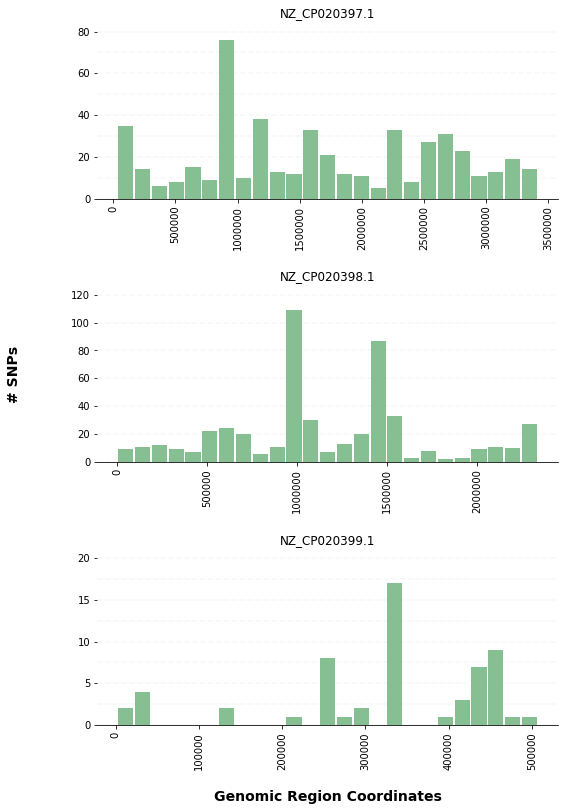

In [155]:
#Groups table by chromosome and sorts by position value
#variants.groupby('Chromosome').apply(lambda x: x.sort_values('Position'))

#Makes histogram of position values in bins of 25  
pos_his = variants.hist(column="Position", by="Chromosome", bins=25, grid=False, figsize=(8,13), layout=(3,1), zorder=2, rwidth= .9, color='#86bf91')
for i,x in enumerate(pos_his):

    # Remove edges 
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)


    # Set x and y-axis labels
    if i == 1:
        x.set_ylabel("# SNPs", labelpad=50, weight='bold', size=14)
    elif i == 2:
        x.set_xlabel("Genomic Region Coordinates", labelpad=20, weight='bold', size=14)


<div class="alert alert-block alert-warning">
    <b> Part 2: Extraction of Dense Mutation Regions/Genes </b> 
</div>

- Split location span into bins of 1000 for each chromosome and extract the most densly packed with mutations   
- Use the GFF file to find all genes within those areas and make table of all genes and another with just coding genes so can look at protein products

In [106]:
#creating dataframe from above variants table and chose bin size of 100 
mutation_regions = getMutRegions(variants, 1000)
mutation_regions

,Regions,# SNPs,% Total on Chrom,Chromosome
0,"(908516.187, 911902.18]",32,6.438632,NZ_CP020397.1
1,"(1199711.585, 1203097.578]",28,5.633803,NZ_CP020397.1
2,"(905130.194, 908516.187]",24,4.828974,NZ_CP020397.1
3,"(2747110.386, 2750496.379]",18,3.621730,NZ_CP020397.1
4,"(1531538.899, 1534924.892]",14,2.816901,NZ_CP020397.1
...,...,...,...,...
2995,"(325295.52, 325800.563]",0,0.000000,NZ_CP020399.1
2996,"(324790.477, 325295.52]",0,0.000000,NZ_CP020399.1
2997,"(324285.434, 324790.477]",0,0.000000,NZ_CP020399.1
2998,"(323780.391, 324285.434]",0,0.000000,NZ_CP020399.1


In [107]:
#only want regions with signifcantly higher proportions of mutations than would be assumed by equal distribution. 
#Extracted regions containing greater than 5% of total on chromosome 
#since regions split into 1000 bins on each chromosome, locations containing >5% of total shows significant enrichment in area
#Is speculated that regions with high numbers of SNPs may be targets of recombination 

highest_muts = mutation_regions.loc[mutation_regions['% Total on Chrom'] >= 5]
highest_muts

,Regions,# SNPs,% Total on Chrom,Chromosome
0,"(908516.187, 911902.18]",32,6.438632,NZ_CP020397.1
1,"(1199711.585, 1203097.578]",28,5.633803,NZ_CP020397.1
1000,"(1473014.46, 1475352.102]",79,15.705765,NZ_CP020398.1
1001,"(972759.072, 975096.714]",60,11.928429,NZ_CP020398.1
2000,"(342466.982, 342972.025]",7,11.864407,NZ_CP020399.1
2001,"(445495.754, 446000.797]",6,10.169492,NZ_CP020399.1
2002,"(451051.227, 451556.27]",5,8.474576,NZ_CP020399.1
2003,"(342972.025, 343477.068]",5,8.474576,NZ_CP020399.1
2004,"(341961.939, 342466.982]",4,6.779661,NZ_CP020399.1
2005,"(247518.898, 248023.941]",4,6.779661,NZ_CP020399.1


In [108]:
#creating dictionary for input
high_dict = RegionGFF_input(highest_muts)
print(high_dict)

{'NZ_CP020397.1': [[908516, 911902], [1199712, 1203098]], 'NZ_CP020398.1': [[1473014, 1475352], [972759, 975097]], 'NZ_CP020399.1': [[342467, 342972], [445496, 446001], [451051, 451556], [342972, 343477], [341962, 342467], [247519, 248024]]}


In [109]:
#Need GFF of reference that called variants from in order to extract gene information
my_GFF = "/Users/sarahharrison/Documents/GitHub/CF-BM-WGS-data-analysis/reference_data/GCF_003019965.1_ASM301996v1_genomic.gff"

high_region_gene_data = makeGeneFrame(high_dict, my_GFF, 'gene')
high_region_gene_data

,Biotype,Start_Pos,Stop_Pos,Strand,Chromosome
Gene,,,,,
A8H40_RS04480,protein_coding,905635,911430,+,NZ_CP020397.1
A8H40_RS04485,protein_coding,911741,912100,+,NZ_CP020397.1
A8H40_RS05970,protein_coding,1198495,1200207,+,NZ_CP020397.1
A8H40_RS05975,protein_coding,1200230,1200553,+,NZ_CP020397.1
A8H40_RS05980,protein_coding,1200766,1201059,+,NZ_CP020397.1
A8H40_RS05985,protein_coding,1201114,1202286,+,NZ_CP020397.1
A8H40_RS05990,protein_coding,1202377,1203777,+,NZ_CP020397.1
A8H40_RS23585,protein_coding,1471394,1473058,-,NZ_CP020398.1
A8H40_RS23590,protein_coding,1473409,1475376,+,NZ_CP020398.1


In [110]:
#To see what protein coding products associated with SNP rich areas made CDSframe
#Since majority from above are protein coding

high_region_CDS_data = makeGeneFrame(high_dict, my_GFF, 'CDS')
high_region_CDS_data

,Protein Product,Start_Pos,Stop_Pos,Chromosome,Strand
Gene,,,,,
A8H40_RS04480,S-layer family protein,905635,911430,NZ_CP020397.1,+
A8H40_RS04485,hypothetical protein,911741,912100,NZ_CP020397.1,+
A8H40_RS05970,30S ribosomal protein S1,1198495,1200207,NZ_CP020397.1,+
A8H40_RS05975,integration host factor subunit beta,1200230,1200553,NZ_CP020397.1,+
A8H40_RS05980,LapA family protein,1200766,1201059,NZ_CP020397.1,+
A8H40_RS05985,lipopolysaccharide assembly protein LapB,1201114,1202286,NZ_CP020397.1,+
A8H40_RS05990,UDP-glucose/GDP-mannose dehydrogenase family p...,1202377,1203777,NZ_CP020397.1,+
A8H40_RS23585,acid phosphatase,1471394,1473058,NZ_CP020398.1,-
A8H40_RS23590,ATP-dependent metallopeptidase FtsH/Yme1/Tma f...,1473409,1475376,NZ_CP020398.1,+


In [111]:
###Working on visualizing these regions in Mauve to analyze potential recombination  

<div class="alert alert-block alert-warning">
    <b> Part 3: Annotation of All Coding Genes Containing SNPs With Counts </b> 
</div>

- Looking for genes with abnormally high numbers as this might be a clue for selective pressure on this gene  
- Also categorizing data to see if any particular protein types are being seen to contain higher numbers of  mutations  
- Tables from before didnt ensure that a mutation was located in those genes was just finding ALL genes in that region on chromosome that contained a high number of SNPs so wanted to ensure that all genes found contained SNP

In [112]:
#getting all genes into table 
mut_regions = getMutRegions(variants, 100)
#Making dictionary for input
all_GFF_dict = RegionGFF_input(mut_regions)

In [113]:

all_cds_data = makeGeneFrame(all_GFF_dict, my_GFF, 'CDS')

#all 5916 of these genes do not contain a mutation so need to narrow to only the genes that have one
all_cds_data

,Protein Product,Start_Pos,Stop_Pos,Chromosome,Strand
Gene,,,,,
A8H40_RS04365,2-hydroxyacid dehydrogenase,878089,879087,NZ_CP020397.1,-
A8H40_RS04370,LysR family transcriptional regulator,879122,880105,NZ_CP020397.1,-
A8H40_RS04375,hypothetical protein,880456,880857,NZ_CP020397.1,-
A8H40_RS04380,alanine--glyoxylate aminotransferase family pr...,880843,882054,NZ_CP020397.1,+
A8H40_RS04385,helix-turn-helix transcriptional regulator,882073,883008,NZ_CP020397.1,-
...,...,...,...,...,...
A8H40_RS29070,DUF2795 domain-containing protein,314246,314545,NZ_CP020399.1,-
A8H40_RS29830,hydrolase,477879,479003,NZ_CP020399.1,-
A8H40_RS29835,TetR/AcrR family transcriptional regulator,479084,479731,NZ_CP020399.1,+


In [114]:
#Using original variants table to get all positions located in that column
#Both variant table and all_cds_data must be grouped by chromosome

#making new dictionary of genes located in all_cds_data that include a SNP using their start and stop locations
#Iterate through the position table and all_cds_data if the chromosomes match will create list of positions in variant table that correspond to that chromosome
#iterates through the positions and rows of cds table on that chromosome
#determines if position is >= to the start of gene and <= to stop of the gene in order to determine what variants are in which genes

#If determined that variant is in gene will see if gene is in keys of the gene_locs dict if in it appends location to value list of that gene 
#if not in it creates new dictionary key with particuular gene and adds location to its value as a list incase gene has multiple SNPs



group_pos = variants.groupby('Chromosome')

grouped_cds = all_cds_data.groupby('Chromosome')

gene_mut_locs = {}

for chrom, pos in group_pos:
    for ch, region in grouped_cds:
        if chrom == ch:
            positions = pos['Position'].to_list()
            for posi in positions:
                for row in region.itertuples():
                    if posi >= row.Start_Pos and posi <= row.Stop_Pos:
                        if row.Index in gene_mut_locs:
                            gene_mut_locs[row.Index].append(posi)
                        else:
                            gene_mut_locs[row.Index] = [posi]
                            
#More interested currently the number of SNPs that each gene contains and not specific location (will come back to, in order to do sample specific analysis)

#So made a new dictionary just containing the counts on each 

gene_mut_counts = {}
for k,v in gene_mut_locs.items():
    gene_mut_counts[k] = len(v)


In [116]:
#Setting empty columns for count of SNPs and all Locations that contained SNP (for downstream analysis)
all_cds_data['SNP_Count'] = NaN
all_cds_data['SNP_Location'] = ""

#Iterating through data frame index (which is the genes) and if index is in dictionary with the counts will add count to Count Column for each gene
for i,row in all_cds_data.iterrows():
    if i in gene_mut_counts:
        all_cds_data.at[i,'SNP_Count'] = gene_mut_counts[i]
        
#Iterating through data frame index (which is the genes) and if index is in dictionary with the counts will add locations to Location for each gene
for i,row in all_cds_data.iterrows():
    if i in gene_mut_locs:
        all_cds_data.at[i,'SNP_Location'] = gene_mut_locs[i]
        #all_cds_data.at[i,'Location'] = gene_locs[i]

#Had to add .drop because I accidentally added location and count column that I didn't mean to 
#But this extracts all genes from table that have a mutation with counts and locations
cds_genes = all_cds_data.loc[all_cds_data['SNP_Count'] > 0]
cds_genes.sort_values(by='SNP_Count',inplace=True, ascending=False)
top_15 = cds_genes.head(15)

#Showing top 15 genes 
top_15

/Users/sarahharrison/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Protein Product,Start_Pos,Stop_Pos,Chromosome,Strand,SNP_Count,SNP_Location
Gene,,,,,,,
A8H40_RS21335,BapA prefix-like domain-containing protein,970334,978448,NZ_CP020398.1,+,80.0,"[972064, 972076, 972082, 972085, 972122, 97224..."
A8H40_RS23590,ATP-dependent metallopeptidase FtsH/Yme1/Tma f...,1473409,1475376,NZ_CP020398.1,+,79.0,"[1473981, 1474027, 1474035, 1474038, 1474041, ..."
A8H40_RS04480,S-layer family protein,905635,911430,NZ_CP020397.1,+,56.0,"[906345, 906354, 906360, 906618, 906711, 90671..."
A8H40_RS05990,UDP-glucose/GDP-mannose dehydrogenase family p...,1202377,1203777,NZ_CP020397.1,+,32.0,"[1202554, 1202562, 1202565, 1202583, 1202584, ..."
A8H40_RS21405,DUF1275 domain-containing protein,990263,991018,NZ_CP020398.1,-,20.0,"[990273, 990296, 990362, 990368, 990383, 99039..."
A8H40_RS13585,hypothetical protein,2748327,2748685,NZ_CP020397.1,-,18.0,"[2748386, 2748445, 2748447, 2748469, 2748470, ..."
A8H40_RS23950,PAS domain-containing sensor histidine kinase,1555236,1557290,NZ_CP020398.1,+,18.0,"[1556360, 1556363, 1556369, 1556378, 1556399, ..."
A8H40_RS27630,collagen-like triple helix repeat-containing p...,2336935,2339577,NZ_CP020398.1,+,16.0,"[2337228, 2337642, 2337648, 2337681, 2337684, ..."
A8H40_RS23195,membrane protein,1379405,1392133,NZ_CP020398.1,+,15.0,"[1385935, 1385942, 1385959, 1385983, 1385986, ..."


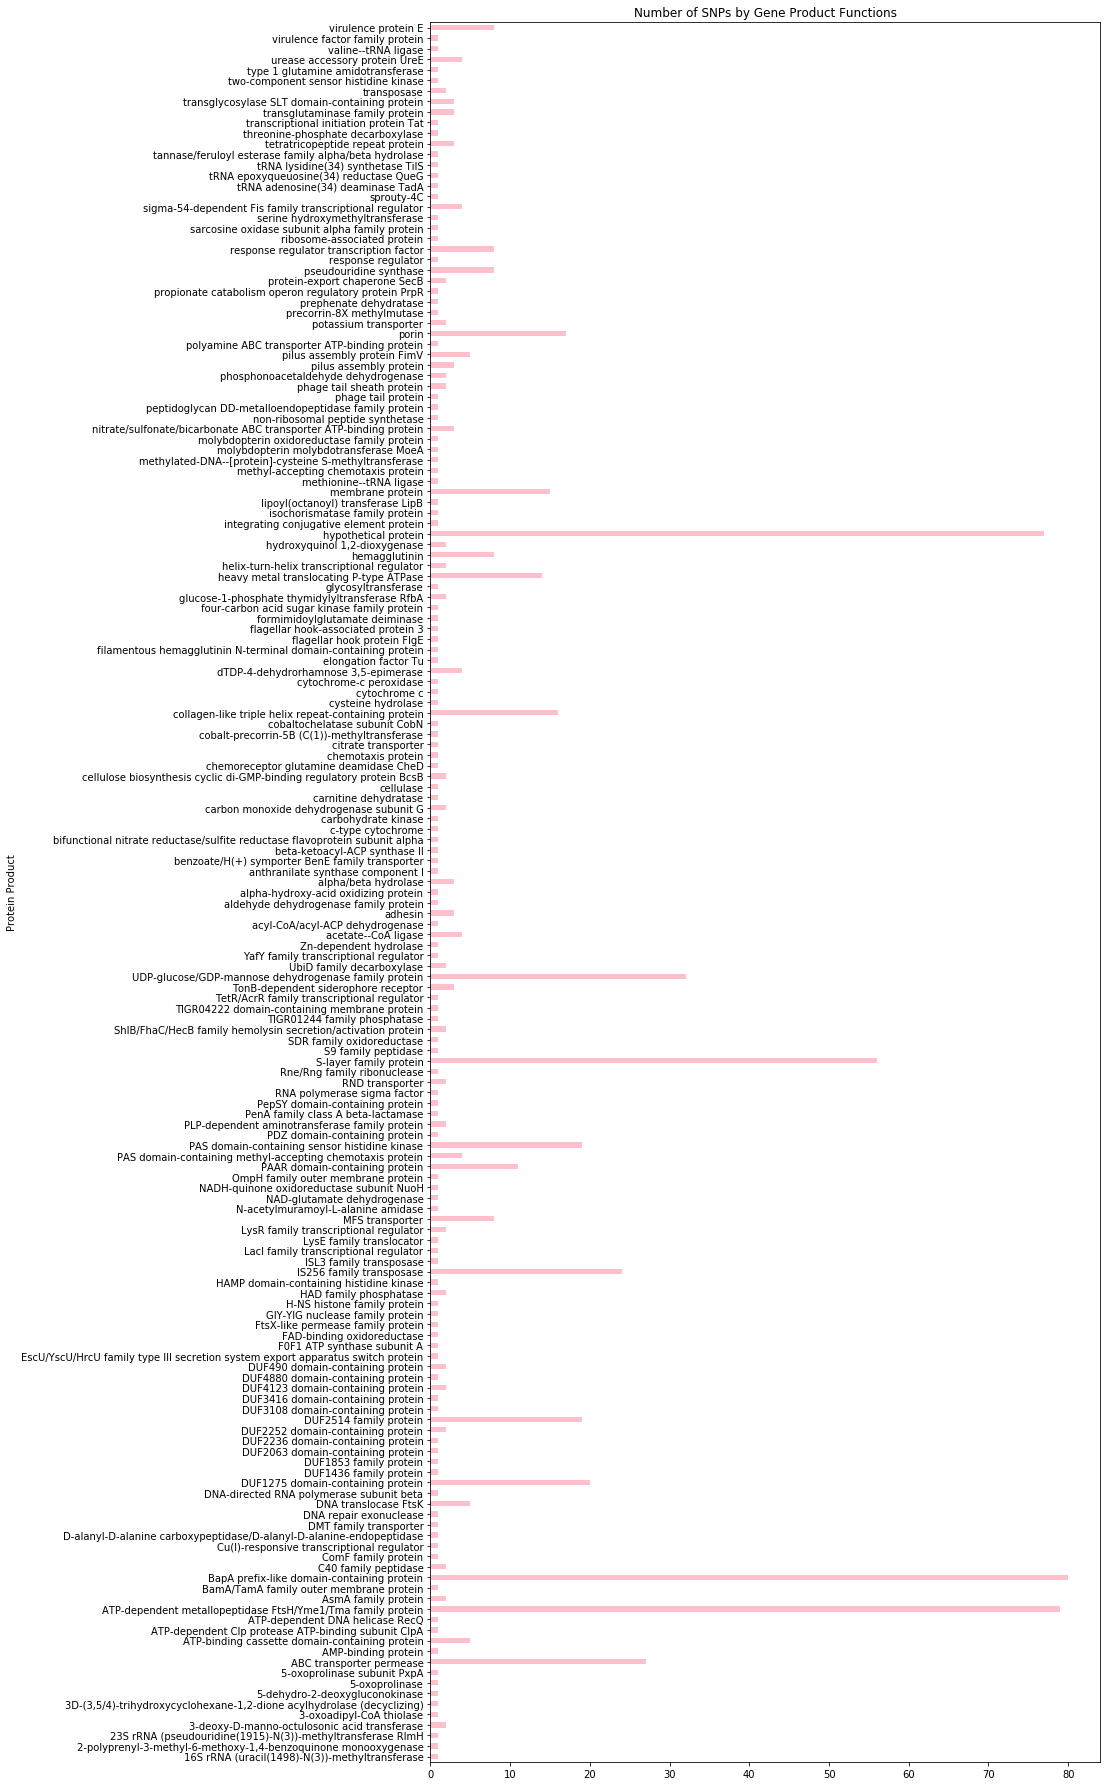

In [172]:
#sums products by count if the same and plots a bar graph of numbers 

grouped_products = cds_genes.groupby("Protein Product")['SNP_Count'].sum()
product_graph = grouped_products.plot(kind='barh', figsize=(12,32), color= "pink", title="Number of SNPs by Gene Product Functions")

In [189]:
#adding column to cds_genes that says whether or not that gene product is mutated another time
mult_mut_product = cds_genes.duplicated(subset='Protein Product', keep=False)
cds_genes['Duplicated'] = mult_mut_product.values
#extracts only genes that have mutated multiple times 
mult_df = cds_genes.loc[cds_genes['Duplicated'] == True]
#makes count of how many times genes of those protein products were mutated on seperate genes 
dups_products = mult_df.pivot_table(index=['Protein Product'], aggfunc='size')
dups_products


/Users/sarahharrison/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Protein Product
ABC transporter permease                                         5
ATP-binding cassette domain-containing protein                   2
DUF2514 family protein                                           2
DUF4123 domain-containing protein                                2
IS256 family transposase                                         9
LysR family transcriptional regulator                            2
MFS transporter                                                  7
PAS domain-containing sensor histidine kinase                    2
ShlB/FhaC/HecB family hemolysin secretion/activation protein     2
TonB-dependent siderophore receptor                              2
UbiD family decarboxylase                                        2
acetate--CoA ligase                                              2
alpha/beta hydrolase                                             2
dTDP-4-dehydrorhamnose 3,5-epimerase                             2
glucose-1-phosphate thymidylyltransferase RfbA

In [102]:
#Function returns table of regions numbers of mutations based on specified bin size in each chromosome 
#Input is dataframe containing "Position" column with all positions which contain mutations as well dataframe must also contain "Chromosome" 
def getMutRegions(data, bins):
    #makes list of chromosomes 
    chroms = list(data.Chromosome.unique()) 
    #creates blank dataframe with desired columns 
    all_reg = pandas.DataFrame(columns=['Regions', '# SNPs', '% Total on Chrom', 'Chromosome'])
    #iterates through chrom list
    for ch in chroms:
        #keeps rows based on chromosome 
        each_chrom = data[data['Chromosome'] == ch]
        #gets positions and splits values into specified bin number
        values = each_chrom['Position'].value_counts(bins=bins)
        #gives fraction of total mutatons on chromosome contained in each each bin region and multiplies by 100 to give percent of total 
        percent_total_chrom = each_chrom['Position'].value_counts(bins=bins, normalize=True) * 100
        #makes new dataframe with desired infomation
        df1 = pandas.DataFrame({'Regions': values.index, '# SNPs' : values.values, '% Total on Chrom': percent_total_chrom.values, 'Chromosome': ch})
        #appends each chromosome info to new dataframe and so easily can group table by chromosome and returns it 
        all_reg = all_reg.append(df1, ignore_index=True)
    return all_reg

#Function creates necessary input for frame making with gene information had to make regions whole numbers
#Also had to remove the ( and ] that is located on the region info and convert to string because that is how the interval info output 
def RegionGFF_input(muts_df):
    regions_dict = {}
    for x in muts_df.Chromosome:
        regions_dict[x] = []
    for reg,chrom in zip(muts_df.Regions, muts_df.Chromosome): 
        new = str(reg)
        no_char = new.rstrip(']').lstrip('(')
        mylist = no_char.split(',')
        rounded_nums = []
        for nums in mylist:
            num = round(float(nums))
            rounded_nums.append(num)
        for k,v in regions_dict.items():
            if chrom == k:
                v.append(rounded_nums)
    return(regions_dict)

def makeGeneFrame(the_GFF_dict, my_gff, option):
    #makes database of gff 
    db = gffutils.create_db(my_gff, dbfn='GFF.db', force=True, keep_order=True,merge_strategy='merge', sort_attribute_values=True)
    
    if option == 'gene':
        #making empty frame with appropriate headers
        all_genes = pandas.DataFrame(columns=['Biotype', 'Start_Pos', 'Stop_Pos', 'Strand', 'Chromosome'])

        #iterating through each chromosomes regions 
        for key,value in the_GFF_dict.items():
            for loc in value:

                #the key is the chromosome and loc[0] is region start and loc[1] is regon end to searcg in gff database

                gene_list = list(db.region(region=(key,
                                                   loc[0], loc[1])))

                #makes lists of all data interested in 
                the_gene_list = []
                start_list = []
                stop_list = []
                biotype_list = []
                strand_list = []

                #looking for all feature types that are genes and appends desired info to them 

                for item in gene_list:
                    if item.featuretype == 'gene':
                        strand_list.append(item.strand)
                        attributes = dict(item.attributes)
                        my_gene = item.id.split('-')[1]
                        the_gene_list.append(my_gene)
                        start_list.append(item.start)
                        stop_list.append(item.stop)
                        biotype = attributes['gene_biotype']
                        biotype_list.append(biotype[0])
                #makes new dataframe with information found for that region        
                gene_data = {'Biotype': biotype_list, 'Start_Pos' : start_list, 'Stop_Pos': stop_list, 'Strand': strand_list, 'Chromosome': key}
                data_fr = pandas.DataFrame(data=gene_data, index=the_gene_list)
                #appends info to list from beginning 
                all_genes = all_genes.append(data_fr)
                
    elif option == "CDS":
        #making empty frame with appropriate headers
        all_genes = pandas.DataFrame(columns=['Protein Product', 'Start_Pos', 'Stop_Pos', 'Chromosome', 'Strand'])

        #iterating through each chromosomes regions 
        for key,value in the_GFF_dict.items():
            for loc in value:

                #the key is the chromosome and loc[0] is region start and loc[1] is regon end to searcg in gff database

                gene_list = list(db.region(region=(key,
                                                   loc[0], loc[1])))
                #makes lists of all data interested in 
                the_gene_list = []
                start_list = []
                stop_list = []
                protein_id_list = []
                strand_list = []
                product_list = []
                #only looking at featuretype CDS and adds information looking for to lists 
                for thing in gene_list:
                    if thing.featuretype == 'CDS':
                        strand_list.append(thing.strand)
                        attributes = dict(thing.attributes)
                        gene_name = attributes['Parent']
                        the_gene_list.append(gene_name[0].split('-')[1])
                        start_list.append(thing.start)
                        stop_list.append(thing.stop)
                        product = attributes['product']
                        product_list.append(product[0])

                #makes new containing what found for that region 
                gene_data = {'Protein Product': product_list, 'Start_Pos' : start_list, 'Stop_Pos': stop_list, 'Chromosome': key, 'Strand': strand_list}
                data_fr = pandas.DataFrame(data=gene_data, index=the_gene_list)

                #appends new data to empty one that made at beginning 
                all_genes = all_genes.append(data_fr)
                
    else:
        print("INVALID FEATURETYPE: Must enter CDS or gene to make the frame")
        
    
    
    #adds gene name as index header, and removes any duplicate genes that were recorded 
    all_genes.index.name = "Gene"
    dedup = all_genes.drop_duplicates()
    #returns new dataframe
    return(dedup)



In [ ]:
###working on plotting by may top 20 product types being mutated?

#### also want to extract each gene from reference then go by location and make consensus sequences for each and change in reference to alt snp from original table then can concat all genes together and make multi fasta to input into muscle to make multisequence alignment and then RAXML

### want to make table that creates matrix for each line of 0,1 if strain contains variant so will extend table with each

### want to make comparisons between strains see if anything cool comes out of that 